In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/liar-fake-news-dataset/test.tsv
/kaggle/input/liar-fake-news-dataset/README
/kaggle/input/liar-fake-news-dataset/train.tsv
/kaggle/input/liar-fake-news-dataset/valid.tsv


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import nltk
import re
import string
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_df = pd.read_csv('/kaggle/input/liar-fake-news-dataset/train.tsv', sep='\t', header=None)
test_df = pd.read_csv('/kaggle/input/liar-fake-news-dataset/test.tsv', sep='\t', header=None)
valid_df = pd.read_csv('/kaggle/input/liar-fake-news-dataset/valid.tsv', sep='\t', header=None)

In [4]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [5]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [6]:
valid_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,NaN
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News


In [5]:
train_df['label']=[1 if x=="true"or x=="mostly-true" else 0 for x in train_df[1]] 
test_df['label']=[1 if x=="true"or x=="mostly-true" else 0 for x in test_df[1]] 
valid_df['label']=[1 if x=="true"or x=="mostly-true" else 0 for x in valid_df[1]] 

In [9]:
df = train_df.append(test_df)
df = df.append(valid_df)
df = df.sample(frac=1).reset_index(drop=True)
df

/tmp/ipykernel_31/3880716038.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train_df.append(test_df)
/tmp/ipykernel_31/3880716038.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(valid_df)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,label
0,13150.json,half-true,Says most illegal immigrants draw welfare bene...,"education,immigration,welfare",tom-delay,Former U.S. House member,Texas,republican,1.0,0.0,1.0,1.0,1.0,an interview on MSNBC,0
1,8608.json,false,"In Wisconsin, more than 300,000 people have so...",gambling,julaine-appling,"Executive Director, Wisconsin Family Action",Wisconsin,none,0.0,2.0,0.0,0.0,0.0,a radio interview,0
2,1256.json,true,"A report by the health insurance industry ""ign...",health-care,nancy-ann-deparle,White House Office of Health Reform Director,NaN,democrat,0.0,0.0,0.0,0.0,0.0,"an interview on ""The NewsHour""",1
3,12481.json,barely-true,Because George Holding doesnt live in the cong...,"congress,debates,redistricting",renee-ellmers,U.S. Representative,North Carolina,republican,1.0,0.0,0.0,0.0,0.0,a debate on WRAL,0
4,13247.json,false,"We are now, for the first time ever, energy in...","energy,environment,gas-prices,trade",hillary-clinton,Presidential candidate,New York,democrat,40.0,29.0,69.0,76.0,7.0,the second presidential debate,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12786,1784.json,half-true,On the importance of judicial experience for S...,legal-issues,john-cornyn,Senator,Texas,republican,5.0,3.0,6.0,2.0,1.0,a news release,0
12787,12897.json,barely-true,The director of the FBI said that we cannot pr...,"immigration,terrorism",carlos-beruff,Developer,Florida,republican,3.0,1.0,0.0,0.0,0.0,a Facebook post,0
12788,2772.json,barely-true,Discretionary spending went up 84 percent in t...,"federal-budget,stimulus",paul-ryan,U.S. Representative,Wisconsin,republican,19.0,6.0,16.0,14.0,2.0,an election-night interview,0
12789,3236.json,false,A proposed immigration bill will bankrupt Geor...,immigration,libertarian-party-georgia,NaN,NaN,libertarian,0.0,1.0,1.0,0.0,0.0,a press release,0


In [10]:
#Below function performs all the required data cleaning and preprocessing steps

def data_preprocessing(dataset):
  #Creating new column called 'label' with 1 for true and mostly-true values, else 0 i.e. 1=real, 0=fake
  dataset['label']=[1 if x=="true"or x=="mostly-true" else 0 for x in dataset[1]] 
  #Dropping unwanted columns
  dataset = dataset.drop(labels=[0,1,8,9,10,11,12] ,axis=1)
  #Dealing with empty datapoints for metadata columns - subject, speaker, job, state,affiliation, context
  meta = []
  for i in range(len(dataset)):
      subject = dataset[3][i]
      if subject == 0:
          subject = 'None'

      speaker =  dataset[4][i]
      if speaker == 0:
          speaker = 'None'

      job =  dataset[5][i]
      if job == 0:
          job = 'None'

      state =  dataset[6][i]
      if state == 0:
          state = 'None'

      affiliation =  dataset[7][i]
      if affiliation == 0:
          affiliation = 'None'

      context =  dataset[13][i]
      if context == 0 :
          context = 'None'

      meta.append(str(subject) + ' ' + str(speaker) + ' ' + str(job) + ' ' + str(state) + ' ' + str(affiliation) + ' ' + str(context)) #combining all the meta data columns into a single column
  
  #Adding cleaned and combined metadata column to the dataset
  dataset[14] = meta
  dataset["sentence"] = dataset[14].astype('str')+" "+dataset[2] #Combining metadata and the text columns into single columns

  dataset = dataset.drop([2,3,4,5,6,7,13,14], axis=1) #dropping metadata columns, as we have merged them into a single column
  dataset.dropna() #Dropping if there are still any null values

  return dataset

In [11]:
df = data_preprocessing(df)

In [13]:
df

,label,sentence
0,0,"education,immigration,welfare tom-delay Former..."
1,0,"gambling julaine-appling Executive Director, W..."
2,1,health-care nancy-ann-deparle White House Offi...
3,0,"congress,debates,redistricting renee-ellmers U..."
4,0,"energy,environment,gas-prices,trade hillary-cl..."
...,...,...
12786,0,legal-issues john-cornyn Senator Texas republi...
12787,0,"immigration,terrorism carlos-beruff Developer ..."
12788,0,"federal-budget,stimulus paul-ryan U.S. Represe..."
12789,0,immigration libertarian-party-georgia nan nan ...


In [14]:
df.isna().sum()

label       0
sentence    0
dtype: int64

In [15]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [16]:
df['sentence']=df['sentence'].apply(lambda x:review_cleaning(x))
df.head()

,label,sentence
0,0,educationimmigrationwelfare tomdelay former us...
1,0,gambling julaineappling executive director wis...
2,1,healthcare nancyanndeparle white house office ...
3,0,congressdebatesredistricting reneeellmers us r...
4,0,energyenvironmentgaspricestrade hillaryclinton...


In [18]:
stop = stopwords.words('english')
df['sentence'] = df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.head()

,label,sentence
0,0,educationimmigrationwelfare tomdelay former us...
1,0,gambling julaineappling executive director wis...
2,1,healthcare nancyanndeparle white house office ...
3,0,congressdebatesredistricting reneeellmers us r...
4,0,energyenvironmentgaspricestrade hillaryclinton...


In [19]:
max_words = 5000
maxlen = 100
tokenizer0 = Tokenizer(num_words=max_words)
tokenizer0.fit_on_texts(df['sentence'])
train_sequences = tokenizer0.texts_to_sequences(df['sentence'])
x = pad_sequences(train_sequences, maxlen=maxlen)

y = df['label']
y = pd.get_dummies(y)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# CNN

In [21]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense

In [23]:
model = Sequential()
model.add(Embedding(max_words, 64, input_length=maxlen))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           320000    
                                                                 
 conv1d (Conv1D)             (None, 96, 32)            10272     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                        

In [26]:
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
160/160 [==============================] - 20s 78ms/step - loss: 0.6466 - accuracy: 0.6371 - val_loss: 0.6251 - val_accuracy: 0.6471
Epoch 2/5
160/160 [==============================] - 5s 31ms/step - loss: 0.5772 - accuracy: 0.6949 - val_loss: 0.6161 - val_accuracy: 0.6608
Epoch 3/5
160/160 [==============================] - 3s 16ms/step - loss: 0.4101 - accuracy: 0.8182 - val_loss: 0.6977 - val_accuracy: 0.6491
Epoch 4/5
160/160 [==============================] - 1s 9ms/step - loss: 0.1825 - accuracy: 0.9399 - val_loss: 0.9264 - val_accuracy: 0.6409
Epoch 5/5
160/160 [==============================] - 1s 9ms/step - loss: 0.0490 - accuracy: 0.9902 - val_loss: 1.1676 - val_accuracy: 0.6221


In [27]:
y_pred0 = model.predict(X_test)
y_pred0 = [1 if x[1]>0.5 else 0 for x in y_pred0]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test.iloc[:,1], y_pred0))
print('Classification Report:')
print(classification_report(y_test.iloc[:,1], y_pred0))

80/80 [==============================] - 0s 2ms/step
Accuracy: 0.6232903477921062
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71      1654
           1       0.47      0.44      0.45       905

    accuracy                           0.62      2559
   macro avg       0.58      0.58      0.58      2559
weighted avg       0.62      0.62      0.62      2559



In [28]:
cm_cv = confusion_matrix(y_test.iloc[:,1],y_pred0)
cm_cv

array([[1198,  456],
       [ 508,  397]])

In [29]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

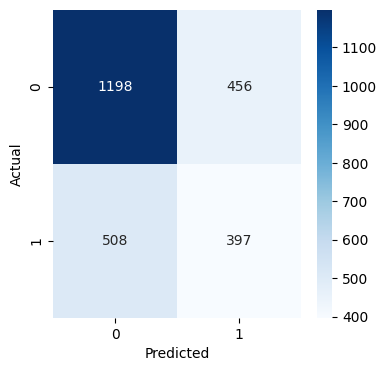

In [30]:
plt.figure(figsize = (4,4))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')

# LSTM

In [31]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_words, 64, input_length=maxlen))
model_lstm.add(LSTM(32,dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Flatten())
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(2, activation='sigmoid'))

In [32]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 64)           320000    
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 334,658
Trainable params: 334,658
Non-trainable params: 0
_________________________________________________________________


In [34]:
model_lstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
160/160 [==============================] - 80s 480ms/step - loss: 0.6386 - accuracy: 0.6498 - val_loss: 0.6092 - val_accuracy: 0.6573
Epoch 2/5
160/160 [==============================] - 70s 439ms/step - loss: 0.5583 - accuracy: 0.7093 - val_loss: 0.6310 - val_accuracy: 0.6589
Epoch 3/5
160/160 [==============================] - 70s 436ms/step - loss: 0.4887 - accuracy: 0.7563 - val_loss: 0.6744 - val_accuracy: 0.6401
Epoch 4/5
160/160 [==============================] - 70s 435ms/step - loss: 0.4251 - accuracy: 0.7983 - val_loss: 0.7330 - val_accuracy: 0.6092
Epoch 5/5
160/160 [==============================] - 69s 428ms/step - loss: 0.3614 - accuracy: 0.8393 - val_loss: 0.8775 - val_accuracy: 0.6256


In [35]:
y_pred1 = model_lstm.predict(X_test)
y_pred1 = [1 if x[1]>0.5 else 0 for x in y_pred1]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test.iloc[:,1], y_pred1))
print('Classification Report:')
print(classification_report(y_test.iloc[:,1], y_pred1))

80/80 [==============================] - 2s 24ms/step
Accuracy: 0.6248534583821805
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.76      0.72      1654
           1       0.46      0.38      0.42       905

    accuracy                           0.62      2559
   macro avg       0.58      0.57      0.57      2559
weighted avg       0.61      0.62      0.62      2559



In [45]:
cm_cv = confusion_matrix(y_test.iloc[:,1],y_pred1)
cm_cv

array([[1251,  403],
       [ 557,  348]])

In [46]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

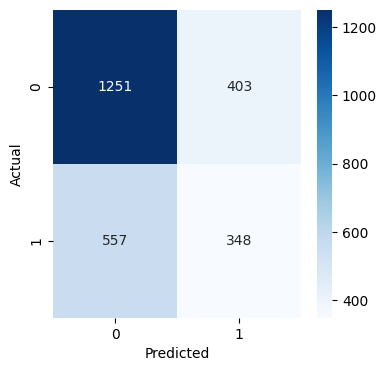

In [47]:
plt.figure(figsize = (4,4))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')

# Bi-Lstm

In [51]:
model_bilstm = Sequential()
model_bilstm.add(Embedding(max_words, 64, input_length=maxlen))
model_bilstm.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model_bilstm.add(Flatten())
model_bilstm.add(Dense(64, activation='relu'))
model_bilstm.add(Dense(2, activation='sigmoid'))

In [52]:
model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
model_bilstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 64)           320000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              132000    
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                12864     
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                                 
Total params: 464,994
Trainable params: 464,994
Non-trainable params: 0
________________________________________________

In [54]:
model_bilstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
160/160 [==============================] - 147s 883ms/step - loss: 0.6407 - accuracy: 0.6507 - val_loss: 0.6104 - val_accuracy: 0.6721
Epoch 2/5
160/160 [==============================] - 136s 851ms/step - loss: 0.5580 - accuracy: 0.7090 - val_loss: 0.6242 - val_accuracy: 0.6631
Epoch 3/5
160/160 [==============================] - 135s 845ms/step - loss: 0.4740 - accuracy: 0.7689 - val_loss: 0.6823 - val_accuracy: 0.6307
Epoch 4/5
160/160 [==============================] - 134s 835ms/step - loss: 0.3993 - accuracy: 0.8186 - val_loss: 0.8136 - val_accuracy: 0.6381
Epoch 5/5
160/160 [==============================] - 134s 839ms/step - loss: 0.3376 - accuracy: 0.8546 - val_loss: 0.9737 - val_accuracy: 0.6299


In [44]:
y_pred2 = model_bilstm.predict(X_test)
y_pred2 = [1 if x[1]>0.5 else 0 for x in y_pred2]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test.iloc[:,1], y_pred2))
print('Classification Report:')
print(classification_report(y_test.iloc[:,1], y_pred2))

80/80 [==============================] - 5s 54ms/step
Accuracy: 0.6174286830793279
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.73      0.71      1654
           1       0.45      0.41      0.43       905

    accuracy                           0.62      2559
   macro avg       0.57      0.57      0.57      2559
weighted avg       0.61      0.62      0.61      2559



In [48]:
cm_cv = confusion_matrix(y_test.iloc[:,1],y_pred2)
cm_cv

array([[1210,  444],
       [ 535,  370]])

In [49]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

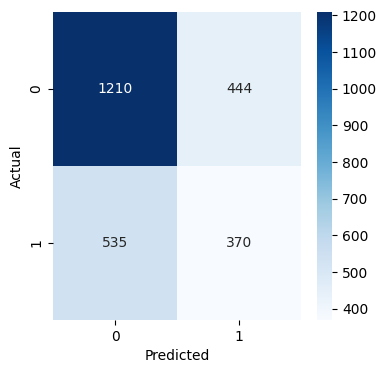

In [50]:
plt.figure(figsize = (4,4))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')